# Paper *Self-Supervised Generalisation with Meta Auxiliary Learning*

https://papers.nips.cc/paper/2019/file/92262bf907af914b95a0fc33c3f33bf6-Paper.pdf

Using an auxiliary loss is called auxiliary learning, and is similar to multi-task learning, except that only the primary task is of interest. In our case, the primary task is to output whether image 1 is a digit smaller than image 2. The role of the auxiliary task is to assist in generalization of this primary task.

This paper discusses unsupervised auxiliary learning, for the cases when no label exist for the auxiliary task. Note: this is not our case, we have the original labels $\{0, 1, \dots, 9\}$ from which we deduce the boolean value. Also, the project presentation PDF mentions:

> For the [auxiliary loss], the training can in particular take advantage of the availability of the classes of the two digits in each pair, beside the Boolean value truly of interest. 


# Google paper "Going deeper with convolutions"

https://arxiv.org/abs/1409.4842

https://stats.stackexchange.com/questions/304699/what-is-auxiliary-loss-as-mentioned-in-pspnet-paper



The paper from Google introduced the concept of auxiliary loss. But the focus is to improve very deep networks (they describe a 22-layer long network), whereas we don't really have deep networks for our simple task. The basic idea is to add **auxiliary classifiers connected to intermediate layers**. This is especially useful to **fight gradient vanishing and add regularization**.

### Structure of extra network

1. Average pooling layer
1. 1x1 convolution for dimension reduction and relu activation
1. fully connected and relu
1. dropout (70%)
1. linear layer with softmax loss as classifier

# Draft ideas for Project 1

Based on this [medium article](https://towardsdatascience.com/improve-your-neural-networks-generalization-performance-by-adding-an-unsupervised-auxiliary-loss-4d58b2dead54), we can combine the main loss with the auxiliary loss for the total loss:

$$\text{total loss} = \text{main loss} + \lambda \cdot \text{auxiliary loss}$$

Also, since our network is *not* deep (and can't be, because computations must be rather fast as mentionned in the project description), we should probably put the auxiliary classifier at the end of the network, and not at intermediate levels (as done in Google paper). 

Also, we must combine the main and auxiliary loss in a meaningful way:

* Main loss is currently an accuracy 
* Auxiliary loss would probably be categorical cross entropy

We should probably change the main loss to something more related to the multi-class entropy. 

# Implementation

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

In [2]:
try:
    import google.colab
    # At this point, we know we're in google collab
    DOWNLOAD = True
except:
    DOWNLOAD = not Path('MNIST').exists()

## dataset build

In [3]:
if DOWNLOAD:
    !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
    !tar -xf MNIST.tar.gz
    print('Download finished...')

--2021-03-14 11:33:45--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-14 11:33:45--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [           <=>      ]  33.20M  15.2MB/s    in 2.2s    

2021-03-14 11:33:48 (15.2 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

Download finished...


In [4]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [5]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

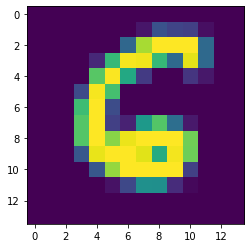

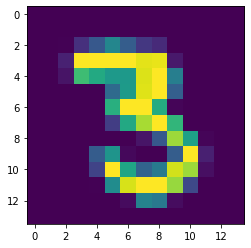

train shape : torch.Size([1000, 2, 14, 14])


In [6]:
plt.imshow( train_input[0][0].numpy() ) 
plt.show()
plt.imshow( train_input[0][1].numpy() ) 
plt.show()
print(f'train shape : {train_input.shape}')

In [7]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
train_dataloader = DataLoader(train_dataset , batch_size=100)

test_dataset = TensorDataset(test_input,test_target , test_classes)
test_dataloader = DataLoader(test_dataset , batch_size=100)


# Fully dense net with aux loss


In [8]:
class FullyDenseNet(nn.Module):
    def __init__(self):
        super(FullyDenseNet, self).__init__()

        self.fc1 = nn.Linear(2*14*14, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = torch.relu( self.fc4(x) )
        x = self.fc5(x)
        return torch.sigmoid(x)

In [23]:
class FullyDenseNetAux(nn.Module):
    def __init__(self):
        super(FullyDenseNetAux, self).__init__()

        # Network basis: common for all losses
        # 14 * 14 = 196
        self.fc1_im1 = nn.Linear(14*14, 100)
        self.fc1_im2 = nn.Linear(14*14, 100)
        
        self.fc2_im1 = nn.Linear(100, 50)
        self.fc2_im2 = nn.Linear(100, 50)
        
        # Auxiliary networks
        self.fc3_im1 = nn.Linear(50, 10)
        self.fc3_im2 = nn.Linear(50, 10)
        
        # Main task
        self.fc4 = nn.Linear(2*50, 10)
        self.fc5 = nn.Linear(10, 1)

    def forward(self, x):
        im1 = nn.Flatten()(x[:, 0, :, :])
        im2 = nn.Flatten()(x[:, 1, :, :])
        
        im1 = torch.relu(self.fc1_im1(im1))
        im2 = torch.relu(self.fc1_im2(im2))
        
        im1 = torch.relu(self.fc2_im1(im1))
        im2 = torch.relu(self.fc2_im2(im2))
        
        # Main task
        common = torch.cat((im1, im2), dim=1)
        common = torch.relu(self.fc4(common))
        common = self.fc5(common)
        common = torch.sigmoid(common)
        
        # Auxiliary networks
        im1 = self.fc3_im1(im1)
        im1 = F.softmax(im1, dim=0)
        
        im2 = self.fc3_im2(im2)
        im2 = F.softmax(im2, dim=0)
        
        return common, im1, im2

# Train tools

In [10]:
def custom_loss(output, target, classes, lambda_=1.0):
  """
  Custom loss for network with auxiliary losses. The total loss is a combination
  of the loss of the main task (binary cross entropy) and the negative log likelihood
  for the two auxiliary tasks. Importance of auxiliary losses is controlled by
  the `lambda_` hyperparameter.
  """
  main, im1, im2 = output

  main_loss = F.binary_cross_entropy(main.flatten(), target)
  aux_loss_1 = F.nll_loss(im1, classes[:, 0])
  aux_loss_2 = F.nll_loss(im2, classes[:, 1])

  return main_loss + lambda_ * (aux_loss_1 + aux_loss_2)

In [11]:
def handle_loss(criterion):
  """
  Handle the fact that the network with auxiliary loss has three-item tuple output,
  which needs to be treated separately to compute the loss and the accuracy.
  """
  if criterion is not custom_loss:
    internal_criterion = lambda output, target, _: criterion(output.flatten(), target)
    compute_acc = lambda output, target: (target == torch.round(output.flatten()) ).sum().item()
  else:
    internal_criterion = criterion
    compute_acc = lambda output, target: (target == torch.round(output[0].flatten()) ).sum().item()
    
  return internal_criterion, compute_acc

In [12]:
def train_epoch(network_ , optimizer_ , criterion = F.binary_cross_entropy ):
  internal_criterion, compute_acc = handle_loss(criterion)
    
  loss_tot = []
  acc_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer_.zero_grad()
    output = network_(data)
    loss = internal_criterion(output, target.to(torch.float32), classes)
    loss.backward()
    optimizer_.step()

    loss_tot.append(loss.item())
    acc_tot.append( compute_acc(output, target) )
  
  return torch.FloatTensor(loss_tot).mean().item() , torch.FloatTensor(acc_tot).mean().item()/100.0

In [13]:
def test(network_ , criterion_ = F.binary_cross_entropy):
  internal_criterion, compute_acc = handle_loss(criterion_)

  network_.eval()
  test_loss = 0
  acc = 0

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      test_loss += internal_criterion(output, target.to(torch.float32), classes)
      acc += compute_acc(output, target)

  test_loss /= len(test_dataloader)
  acc /= len(test_dataloader)
  return test_loss , acc/100.0

In [14]:
def train(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):
    train_loss , train_acc = train_epoch(network_ , optimizer_ , criterion_)
    test_loss , test_acc = test(network_ , criterion_)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

    if(debug_):
      print(epoch, f'{train_loss:.4}\t{train_acc:.4}\t{test_loss:.4}\t{test_acc:.4}')

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

# Auxiliary task

In [15]:
net = FullyDenseNet()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(net, optimizer, F.binary_cross_entropy)

0 0.6696	0.604	0.57	0.71
1 0.5345	0.732	0.5502	0.7
2 0.4499	0.783	0.5705	0.691
3 0.4016	0.819	0.5403	0.723
4 0.3622	0.841	0.5014	0.751
5 0.3598	0.836	0.4694	0.77
6 0.3376	0.844	0.5858	0.708
7 0.294	0.879	0.6945	0.696
8 0.2416	0.912	0.7627	0.692
9 0.1927	0.935	0.7615	0.702
10 0.1452	0.954	0.6071	0.755
11 0.1702	0.935	0.5532	0.782
12 0.1532	0.957	0.5263	0.775
13 0.1286	0.957	0.488	0.787
14 0.1267	0.958	0.6736	0.733
15 0.08596	0.983	0.8368	0.707
16 0.07419	0.984	0.5473	0.784
17 0.1329	0.948	0.5481	0.786
18 0.07619	0.98	0.5344	0.791
19 0.03894	0.997	0.7462	0.772
20 0.05215	0.99	0.7355	0.78
21 0.0601	0.98	0.6454	0.78
22 0.01342	1.0	0.6019	0.792
23 0.007263	1.0	0.6236	0.794
24 0.005722	1.0	0.6415	0.795
25 0.004682	1.0	0.6548	0.795
26 0.003971	1.0	0.6669	0.795
27 0.003464	1.0	0.6776	0.794
28 0.003056	1.0	0.6869	0.793
29 0.002743	1.0	0.6955	0.793


In [25]:
net = FullyDenseNetAux()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(net, optimizer, criterion_=custom_loss)

0 0.6329	0.593	0.5411	0.691
1 0.4889	0.712	0.4745	0.727
2 0.4014	0.771	0.426	0.751
3 0.327	0.809	0.4065	0.751
4 0.2771	0.819	0.3905	0.757
5 0.2203	0.853	0.3781	0.779
6 0.1935	0.865	0.4598	0.741
7 0.1912	0.855	0.3626	0.787
8 0.1513	0.872	0.3633	0.789
9 0.07604	0.922	0.5338	0.741
10 0.1249	0.892	0.5897	0.733
11 0.07778	0.919	0.7477	0.714
12 0.06539	0.928	0.6755	0.725
13 0.04246	0.927	0.4922	0.763
14 0.05387	0.914	0.405	0.788
15 0.006711	0.947	0.3939	0.789
16 -0.01012	0.946	0.4308	0.791
17 -0.0212	0.946	0.4286	0.794
18 -0.01743	0.944	0.4671	0.788
19 0.005617	0.935	0.4958	0.787
20 -0.02793	0.959	0.5668	0.768
21 -0.01141	0.939	0.6806	0.75
22 -0.04261	0.947	0.6616	0.747
23 -0.08831	0.972	0.4298	0.806
24 -0.1296	0.991	0.4167	0.806
25 -0.1478	0.999	0.4391	0.816
26 -0.1552	1.0	0.4583	0.815
27 -0.1594	1.0	0.4719	0.816
28 -0.1622	1.0	0.4845	0.816
29 -0.1641	1.0	0.4967	0.815


# stats

In [17]:
import seaborn as sns
sns.set(style='whitegrid')

In [18]:
def train_multiple_runs(network_class, criterion=F.binary_cross_entropy, runs = 10 , epoch = 30):
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = [],[],[],[]
  
  for i in range(runs):
    n = network_class()
    optimizer = optim.SGD(n.parameters(), lr=0.01, momentum=0.5)

    tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(n , optimizer , criterion , epoch , debug_ = False)
    all_train_loss.append(tot_train_loss)
    all_train_acc.append(tot_train_acc)
    all_test_loss.appendnn.functional.sigmoid(tot_test_loss)
    all_test_acc.append(tot_test_acc)

  return all_train_loss , all_train_acc , all_test_loss , all_test_acc

In [19]:
def plot_loss_acc( tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc ):
  epochs = range(1, len(tot_train_loss)+1 )
  plt.plot(epochs, tot_train_loss, 'g', label='Training loss')
  plt.plot(epochs, tot_test_loss, 'b', label='Test loss')
  plt.plot(epochs, tot_train_acc, 'r', label='Training acc')
  plt.plot(epochs, tot_test_acc, 'y', label='Test acc')
  plt.title('Training and Test loss/acc')
  plt.xlabel('Epochs')
  plt.ylabel('loss/acc')
  plt.ylim((0,1))
  plt.legend()
  plt.show()

In [20]:
def plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc):
  def subplot(ax, mean, std, label=None):
    x = range(1, len(mean) + 1)
    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean - std, mean + std, alpha=0.3)

  # Convert lists of lists to tensors
  data = {
      'loss_train': all_train_loss,
      'loss_test' : all_test_loss,
      'acc_train':  all_train_acc,
      'acc_test':   all_test_acc
  }

  data = {k: torch.tensor(v) for k, v in data.items()}

  # Compute mean and std. The multiple runs are in axis 0, epochs in axis 1
  plot_data = {}
  for label, tensor in data.items():
    plot_data[f'{label}_mean'] = tensor.mean(dim=0)
    plot_data[f'{label}_std'] = tensor.std(dim=0)
    
  # Plot!
  fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 5))
  subplot(ax[0], plot_data['loss_train_mean'], plot_data['loss_train_std'], label='train')
  subplot(ax[0], plot_data['loss_test_mean'], plot_data['loss_test_std'], label='test')
  ax[0].set_ylabel('Loss')
  subplot(ax[1], plot_data['acc_train_mean'], plot_data['acc_train_std'])
  subplot(ax[1], plot_data['acc_test_mean'], plot_data['acc_test_std'])
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')

  ax[0].legend()

In [26]:
all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs(FullyDenseNetAux, 
                                                                                    criterion=custom_loss,
                                                                                    epoch=25)

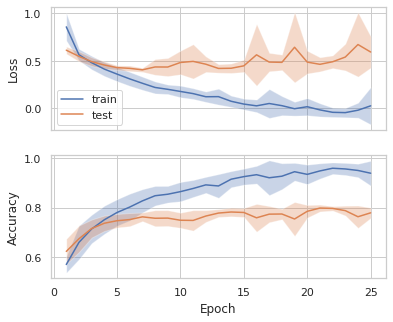

In [27]:
plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc)